In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import gzip
import pickle
import torch

# Imágenes astronómicas

## Integrantes:
    - Maria Jose Nunez
    - Felipe Quezada

Las imágenes astrónomicas usualmente se guardan en formato FITS

Podemos usar la librería [astropy](https://docs.astropy.org/en/stable/io/fits/) para abrir y manipular estos archivos

El repositorio tiene una imagen de ejemplo en la carpeta `../data`

Algunos atributos importantes son
- `info()` para explorar el contenido del archivo
- `header` para recuperar los parámetros que se usaron para producir la imagen y otra metadata
- `data` para recuperar la imagen en si

Como la imagen tiene "valores extremos" usamos visualizamos su logaritmo

<IPython.core.display.Javascript object>


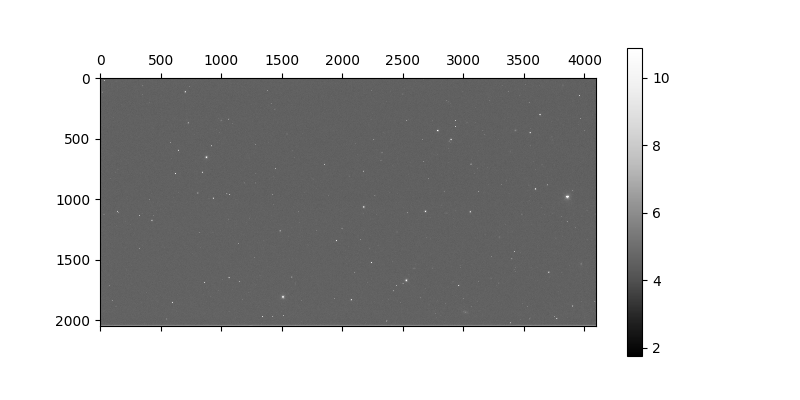

Filename: data/example.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     251   (2048, 4096)   float32   
  1                2 ImageHDU        11   (2048, 4096)   int16 (rescales to uint16)   


None

In [2]:
fig, ax = plt.subplots(figsize=(8, 4))
with gzip.open('data/example.fits.gz') as f:
    with fits.open(f) as hdul:
        display(hdul.info())
        #print(repr(hdul[0].header))
        imap = ax.matshow(np.log(1+hdul[0].data).T, cmap=plt.cm.Greys_r)
        fig.colorbar(imap, ax=ax)

# Detección de transientes y variables con resta de imágenes

<img src="img/image-subtraction.png" width="800">

<img src="img/image-candidates.png" width="800">

<img src="img/image-pipeline.png" width="800">

Usaremos un conjunto de candidatos a transiente obtenidos luego del paso de sustración de imágenes durante el proyecto High Cadence Transient Survey (HiTS) el año 2013

Los candidatos están etiquetados como

- 0 : Candidato real (dominado por artefactos)
- 1 : Candidato sintético insertado en la pipeline

Se [insertaron candidatos sintéticos](https://iopscience.iop.org/article/10.1086/519832/meta) para balancear el dataset y entrenar un clasificador, originalmente un [random forest](https://iopscience.iop.org/article/10.3847/0004-637X/832/2/155/meta) y luego una [red neuronal convolucional](https://iopscience.iop.org/article/10.3847/1538-4357/836/1/97/pdf)

Cada candidato está representado por tres imágenes de 21x21 pixeles

- 0: Imagen de diferencia
- 1: Imagen de ciencia
- 2: Imagen de referencia

In [32]:
from torch.utils.data import TensorDataset, DataLoader, Subset 
import pandas as pd

df_trainimage = pd.read_csv("HiTS_500k/images_train.csv", header=None)
df_trainlabel = pd.read_csv("HiTS_500k/label_train.csv", header=None)

In [33]:
df_trainimage_new = df_trainimage.drop(df_trainimage.columns[-1], axis=1)

train_data = df_trainimage_new.to_numpy()
train_label = df_trainlabel.to_numpy()

# Reescalamiento a [0, 1]
astro_image_tensor = torch.from_numpy(train_data.astype('float32')).reshape(-1, 3, 21, 21)
im_min = astro_image_tensor.min(dim=-1).values.min(dim=-1).values.reshape(-1, 3, 1, 1)
im_max = astro_image_tensor.max(dim=-1).values.max(dim=-1).values.reshape(-1, 3, 1, 1)
astro_image_tensor = (astro_image_tensor - im_min)/(im_max-im_min)

# Creación de DataSet y DataLoader
astro_dataset = TensorDataset(astro_image_tensor, torch.from_numpy(train_label))

astro_loader = DataLoader(astro_dataset, 
                          batch_size=128, 
                          shuffle=True)

<IPython.core.display.Javascript object>


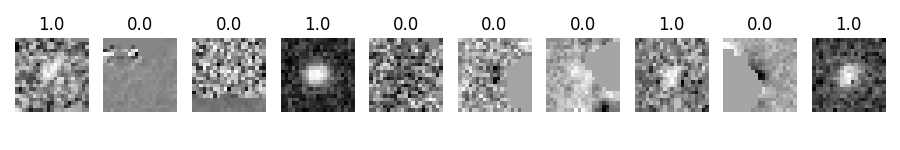

In [34]:
for x, y in astro_loader:
    break
    
fig, ax = plt.subplots(1, 10, figsize=(9, 1.5), tight_layout=True)
for axi, xi, yi in zip(ax, x, y):
    axi.imshow(xi[0], cmap=plt.cm.Greys_r)
    axi.axis('off')
    axi.set_title(yi.item())


El conjunto completo está en `/home/shared/astro/HiTS/HiTS_500k/images_train.csv` como archivo csv

# Tarea final Unidad 5

- Entrenar un GAN con **las imágenes de diferencia** de HiTS
- Reescale las imágenes al rango $[0, 1]$
- Utilice como base la arquitectura [DCGAN](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
- Son libres de experimentar, se premiará la creatividad
- Se trabajará en grupos de a dos
- Recomiendo usar guanaco para hacer los entrenamientos en GPU. Puede usar el ambiente de conda `astro`

## Resumen del trabajo

En este trabajo se implemento un modelo de tipo Condition GAN (CGAN) para generar imagenes de candidatos a transientes astronomicos. La razon de usar una Conditional GAN fue ya existe una division implicita en los datos, pues a pesar de que todos corresponden a anomalias, algunos son generados artificialmente y otros no. Esto queda en evidencia al comparar las caracteristicas de los 2 tipos de imagenes. Ademas, afortunadamente se cuenta con el registro de que imagenes son reales (clase 0) y cuales artificiales (clase 1). En base a esto la CGAN es una atractiva herramienta para esta situacion. 

En una primera instacia se implemento una Deep Convolutional GAN (DCGAN) para solucional el problema, sin embargo, las imagenes generadas tenian unos rasgos vagos de las imagenes del dataset, llegando a resultados pobres. Fue de especial atencion que las imagenes generadas por el DCGAN eran una especia de promedio entre imagenes de clase 0 y 1.

Finalmente se opto por implmentar una combinacion de ambas arquitecturas en una CDCGAN.

El detalle de las arquitecturas del Discriminador y del Generador esta mas abajo, sin emabrgo, solo cuentan con capas convolucionles y de convolucion traspuesta cuando corresponde. A excepcion del Discrminador que tiene una capa fully connected en la cabeza.

Los parametros de entrenamiento son:
    - Tamano de batch: 128
    - Tamano espacio latente: 100
    - Distribucion espacio latente: Normal 0,1
    - Epocas: 15
    - Learning Rate Discriminador: 0.0002
    - Learning Rate Generador: 0.00025
    - beta1: 0.5
    - Inicializacion de pesos en capas convolucionales: Normal(0, 0.01)

Las imagenes del dataset se agrandaron de $21\times21$ a $42\times42$, es decir, se cuadriplicaron en elementos. Esto se hizo ya que se queria mantener aproximadamente la misma cantidad de filtros que las referencias al usar imagenes de un tamano similar. Ademas, de usar filtros de 5x5 [(aqui)](https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9), sin abusar de paddings o strides tremendos, lo que puede significar en una perdida de informacion al grano fino.


#### Referencias

https://arxiv.org/abs/1411.1784

https://github.com/eriklindernoren/PyTorch-GAN

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

https://github.com/soumith/ganhacks

In [14]:
# Number of workers for dataloader
workers = 10

batch_size = 64

image_size = 42

nc = 3

nz = 100

ngf = 50

ndf = 50

# Mejor no cambiar
ngpu = 1


In [5]:
from utils import Generator, Discriminator
# Decide which device we want to run on
ngpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


# Create the generator
netG = Generator(ngpu, nz, ngf, nc).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.

# original saved file with DataParallel
state_dict = torch.load("generator.chk")
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
    
# load params
netG.load_state_dict(new_state_dict)

#netG.load_state_dict(torch.load("generator.chk"))


# Print the model
print(netG)

Generator(
  (conv1_1): ConvTranspose2d(100, 100, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn1_1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): ConvTranspose2d(2, 100, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn1_2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(200, 100, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(100, 50, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn3): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(50, 3, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
  (fin): Tanh()
  (act): ReLU(inplace=True)
)


In [6]:
# Create the Discriminator
netD = Discriminator(ngpu, nc, ndf).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# original saved file with DataParallel
state_dict = torch.load("discriminator.chk")
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
    
# load params
netD.load_state_dict(new_state_dict)
# Print the model
print(netD)


Discriminator(
  (conv1_1): Conv2d(3, 25, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv1_2): Conv2d(2, 25, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(50, 100, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(100, 200, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(200, 1, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False)
  (capa5): Linear(in_features=1600, out_features=1, bias=True)
  (fin): Sigmoid()
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
)


In [12]:
real_label = 0.
fake_label = 1. 

In [15]:
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
fixed_labels1 = torch.ones(batch_size//2,1,1,1)
fixed_labels2 = torch.zeros(batch_size//2,1,1,1)

fixed_labels4 = torch.cat([fixed_labels1, fixed_labels2], dim=1)
fixed_labels3 = torch.cat([fixed_labels2, fixed_labels1], dim=1)

fixed_labels = torch.cat([fixed_labels4, fixed_labels3], dim=0).to(device)



<IPython.core.display.Javascript object>


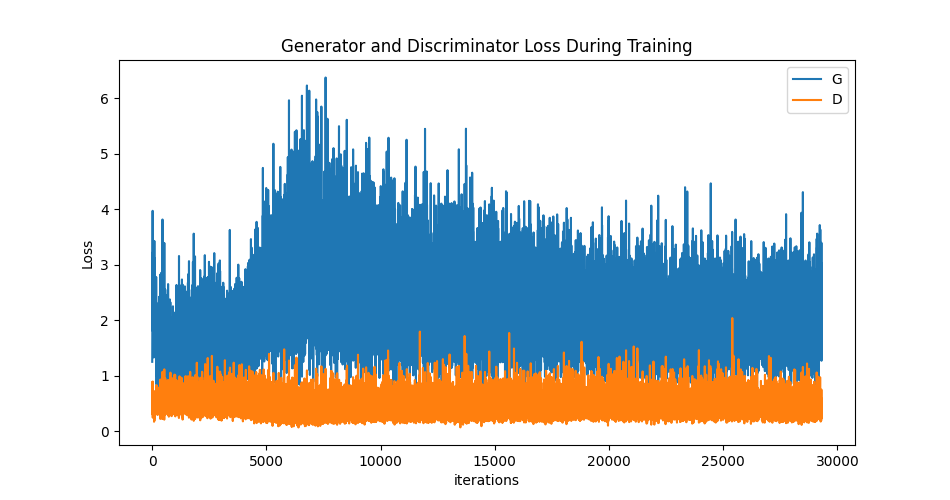

In [9]:
D_losses = np.genfromtxt('dloss.csv', delimiter=',')
G_losses = np.genfromtxt('gloss.csv', delimiter=',')


plt.figure(figsize=(9.5, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")

plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Presentacion de resultados

## Es importante aclarar que en todas las imagenes presentadas mas abajo estan organizadas como: las mitad superior de elementos, ies decir, las 4 primeras filas, corresponden a aquellas imagenes con clase $0$, mientras que el resto a la clase $1$.

In [16]:
fake = netG(fixed_noise, fixed_labels).detach().cpu()

torch.Size([64, 3, 42, 42])

In [99]:
real_indexes = np.random.choice(np.where(np.any(train_label == 0., axis=1))[0], 32, replace=False)
fake_indexes = np.random.choice(np.where(np.any(train_label == 1., axis=1))[0], 32, replace=False)

real_images = astro_image_tensor[real_indexes]
fake_images = astro_image_tensor[fake_indexes]

images = torch.cat([real_images, fake_images], 0)

<IPython.core.display.Javascript object>


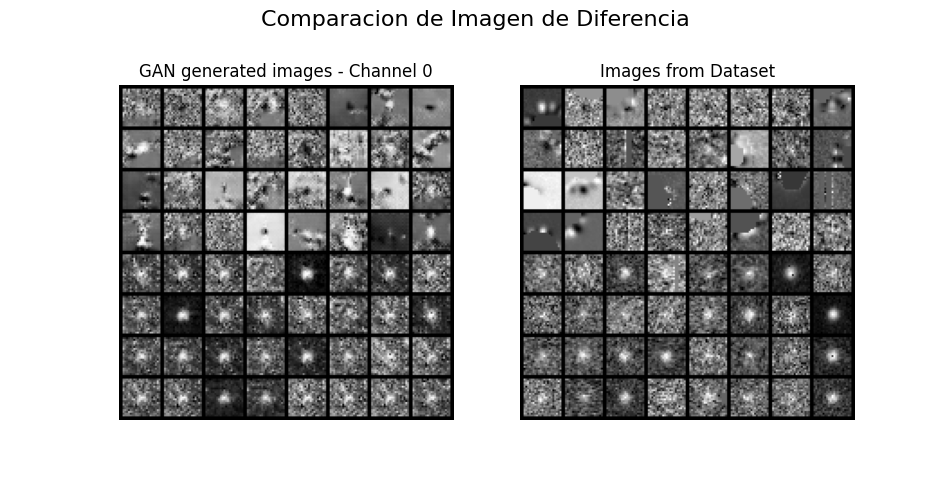

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [106]:
import torchvision.utils as vutils

fig, ax = plt.subplots(1, 2, figsize=(9.5,5))
fig.suptitle('Comparacion de Imagen de Diferencia', fontsize=16)

img = vutils.make_grid(fake[:,0, ::2, ::2].unsqueeze(1), padding=2, normalize=False, nrow=8)
ax[0].axis("off")
ax[0].set_title("GAN generated images")
ax[0].imshow(np.transpose(img, (1,2,0)), cmap=plt.cm.Greys_r)

img = vutils.make_grid(images[:,0, :, :].unsqueeze(1), padding=2, normalize=False, nrow=8)
ax[1].axis("off")
ax[1].set_title("Images from Dataset")

ax[1].imshow(np.transpose(img, (1,2,0)), cmap=plt.cm.Greys_r)


<IPython.core.display.Javascript object>


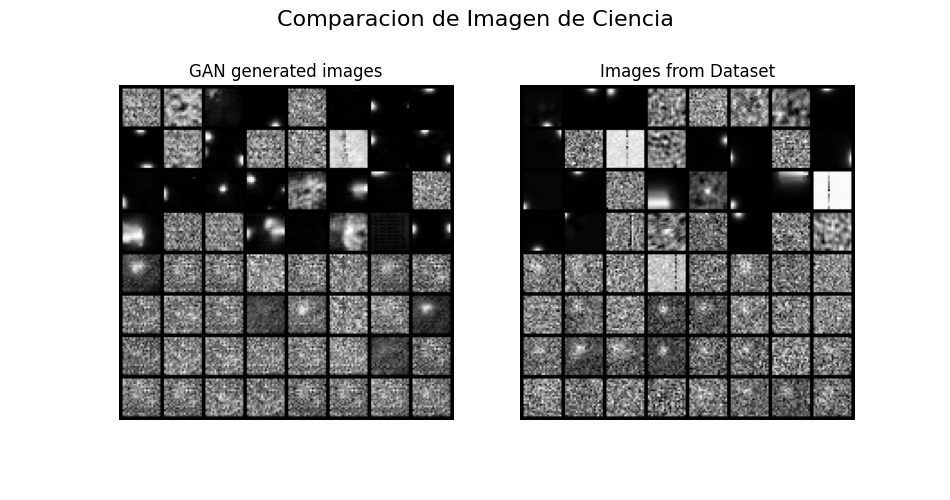

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Images from Dataset')

In [107]:
import torchvision.utils as vutils

fig, ax = plt.subplots(1, 2, figsize=(9.5,5))
fig.suptitle('Comparacion de Imagen de Ciencia', fontsize=16)

img = vutils.make_grid(fake[:,1, ::2, ::2].unsqueeze(1), padding=2, normalize=False, nrow=8)
ax[0].axis("off")
ax[0].set_title("GAN generated images")
ax[0].imshow(np.transpose(img, (1,2,0)), cmap=plt.cm.Greys_r)

img = vutils.make_grid(images[:,1, :, :].unsqueeze(1), padding=2, normalize=False, nrow=8)
ax[1].axis("off")
ax[1].imshow(np.transpose(img, (1,2,0)), cmap=plt.cm.Greys_r)
ax[1].set_title("Images from Dataset")


<IPython.core.display.Javascript object>


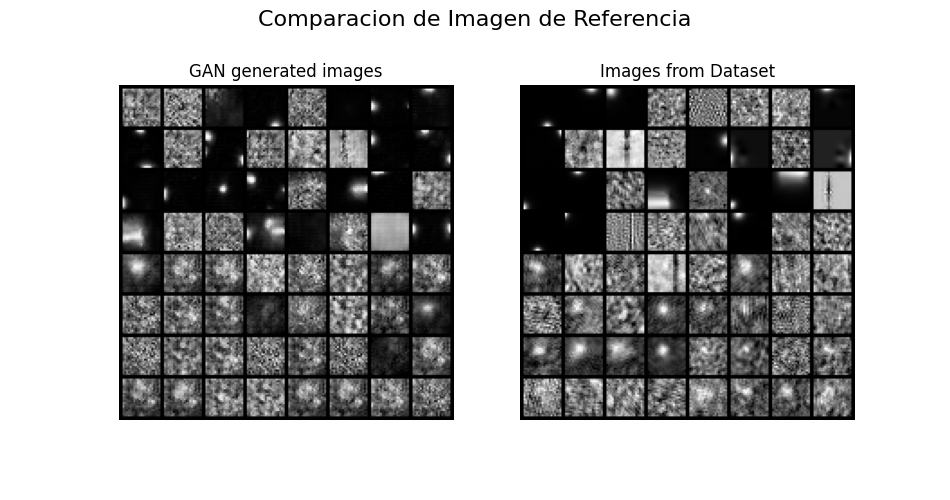

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Images from Dataset')

In [108]:
import torchvision.utils as vutils

fig, ax = plt.subplots(1, 2, figsize=(9.5,5))
fig.suptitle('Comparacion de Imagen de Referencia', fontsize=16)

img = vutils.make_grid(fake[:,2, ::2, ::2].unsqueeze(1), padding=2, normalize=False, nrow=8)
ax[0].axis("off")
ax[0].imshow(np.transpose(img, (1,2,0)), cmap=plt.cm.Greys_r)
ax[0].set_title("GAN generated images")

img = vutils.make_grid(images[:,2, :, :].unsqueeze(1), padding=2, normalize=False, nrow=8)
ax[1].axis("off")
ax[1].imshow(np.transpose(img, (1,2,0)), cmap=plt.cm.Greys_r)
ax[1].set_title("Images from Dataset")


<IPython.core.display.Javascript object>


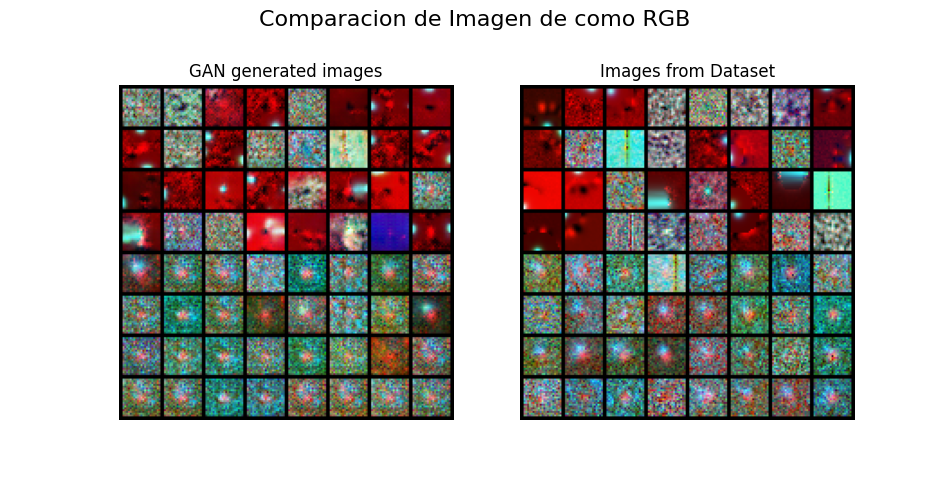

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Images from Dataset')

In [109]:
import torchvision.utils as vutils

fig, ax = plt.subplots(1, 2, figsize=(9.5,5))
fig.suptitle('Comparacion de Imagen de como RGB', fontsize=16)

img = vutils.make_grid(fake[:,:, ::2, ::2], padding=2, normalize=False, nrow=8)
ax[0].axis("off")
ax[0].imshow(np.transpose(img, (1,2,0)))
ax[0].set_title("GAN generated images")

img = vutils.make_grid(images[:,:, :, :], padding=2, normalize=False, nrow=8)
ax[1].axis("off")
ax[1].imshow(np.transpose(img, (1,2,0)))
ax[1].set_title("Images from Dataset")


## Evolucion de imagenes generadas durante el entrenamiento

# Imagen como RGB
![SegmentLocal](gen_channelrgb.gif "gen_channelrgb")

# Imagen de Diferencia

![SegmentLocal](gen_channel0.gif "gen_channel0")

# Imagen de Ciencia
![SegmentLocal](gen_channel1.gif "gen_channel1")

# Imagen de Referencia
![SegmentLocal](gen_channel2.gif "gen_channel2")